# Title: Do women-Led and minority-Led Businesses need more support?

# I. Import libraries and packages

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import data_cleaning as clean
import statsmodels.api as sm
import pylab
from scipy import stats
from statsmodels.formula.api import ols
import scipy.stats as ss
import statsmodels.api as sa
import scikit_posthocs as sp
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# II. Data cleaning by calling functions

The Annual Survey of Entrepreneurs (ASE) provides information on selected economic and demographic characteristics for businesses and business owners by gender, ethnicity, race, and veteran status.

In [2]:
df = clean.full_clean()

# III. Data Analysis

## Part 1: Subset dataframe by genders

## H1: Entrepreneurs, regardless of their genders, pay their employees equally

Subset the dataframe by gender ownership. 

In [3]:
df_sex_female = df.loc[df.sex == 2]
df_sex_male = df.loc[df.sex == 3]
df_sex_both = df.loc[df.sex == 4]

Density plot of annual payroll distribution

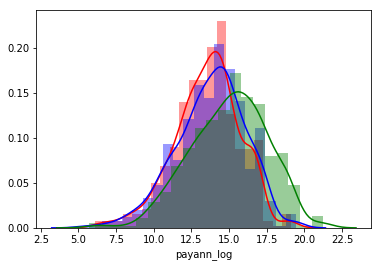

In [4]:
sns.distplot(df_sex_both.payann_log,color="red")
sns.distplot(df_sex_female.payann_log,color="blue")
sns.distplot(df_sex_male.payann_log,color="green")

Normality test

In [5]:
print(stats.shapiro(df_sex_female.payann_log))
print(stats.shapiro(df_sex_male.payann_log))
print(stats.shapiro(df_sex_both.payann_log))

(0.9868340492248535, 4.050735878990963e-05)
(0.9903426170349121, 0.00012920578592456877)
(0.9868038296699524, 2.6033574613393284e-05)


Use non-parametric Kruskal Wallis test, which is a non-parametric equivalent to one-way ANOVA, to compare group means

In [6]:
df_sex_female_payann_list = list(df_sex_female.payann_log)
df_sex_male_payann_list = list(df_sex_male.payann_log)
df_sex_both_payann_list = list(df_sex_both.payann_log)

from scipy.stats import mstats
pval_sex_pay = mstats.kruskalwallis(df_sex_both_payann_list,df_sex_female_payann_list,df_sex_male_payann_list)
pval_sex_pay

KruskalResult(statistic=132.868523906642, pvalue=1.4059394731685496e-29)

QQ plot to see the data distribution

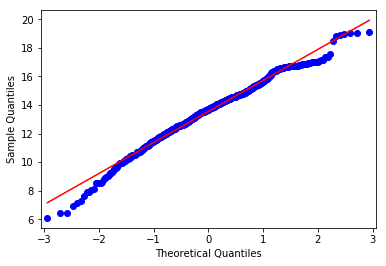

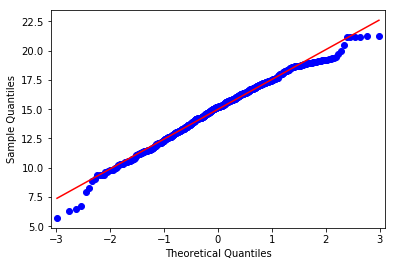

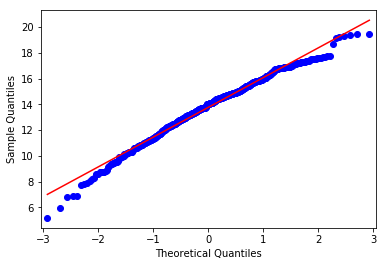

In [7]:
sm.qqplot(df_sex_both.payann_log,line='s')
sm.qqplot(df_sex_male.payann_log,line='s')
sm.qqplot(df_sex_female.payann_log,line='s')
pylab.show()

Although the data did not pass normality test, the result from QQ plot look pretty nice, and does not really violate the one-way ANOVA assumption. Plus, we have a relatively large sample size. 

In [8]:
stats.f_oneway(df_sex_female_payann_list, df_sex_male_payann_list, df_sex_both_payann_list)

F_onewayResult(statistic=72.64489509789207, pvalue=3.964952631136359e-31)

After seeing that the group means are significantly different from each other, I would like to see how far apart they are by generating a violin plot.

### Annual payroll means by owners' gender

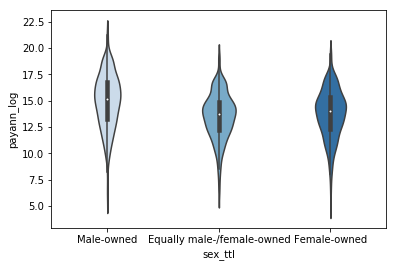

In [9]:
df_sex_payann = df
df_sex_payann = df_sex_payann.loc[(df_sex_payann.sex >1 ) & (df_sex_payann.sex < 5)]
sns.violinplot(x=df_sex_payann.sex_ttl, y=df_sex_payann.payann_log, palette="Blues", width=0.3)

ANOVA again by calling a different function just to see the skewness and Kurtosis

In [10]:
anova_sex_payann = ols('payann_log ~ C(sex_ttl)', data = df_sex_payann).fit()
print(anova_sex_payann.summary())

                            OLS Regression Results                            
Dep. Variable:             payann_log   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     72.64
Date:                Fri, 23 Aug 2019   Prob (F-statistic):           3.96e-31
Time:                        14:14:46   Log-Likelihood:                -4334.9
No. Observations:                1904   AIC:                             8676.
Df Residuals:                    1901   BIC:                             8693.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Further post hoc tests to see if there are any significant differences between groups.

In [11]:
sp.posthoc_conover(df_sex_payann, val_col='payann_log', group_col='sex_ttl', p_adjust = 'bonferroni')

,Equally male-/female-owned,Female-owned,Male-owned
Equally male-/female-owned,-1.000000e+00,1.279038e-01,1.673848e-27
Female-owned,1.279038e-01,-1.000000e+00,3.413060e-18
Male-owned,1.673848e-27,3.413060e-18,-1.000000e+00


Male-owned business has the highese annual payroll mean compared with female- or equally-owned business.

### subset the data by different types of industries to get an idea about how each individual type of business owners pay their employees

### annual payroll by different industry types

In [16]:
df_sex_payann_naics_empszfi = df_sex_payann_naics
df_sex_payann_naics_empszfi = df_sex_payann_naics.loc[(df_sex_payann_naics.empszfi != 1 )]
df_sex_payann_naics_empszfi_empfm = df_sex_payann_naics_empszfi.loc[(df_sex_payann_naics_empszfi.empszfi_ttl != "Firms with no employees")]
df_sex_payann_naics_empszfi_empfm['empszfi_ttl_clean'] = df_sex_payann_naics_empszfi_empfm.empszfi_ttl.apply(lambda x: x[11:-10] if not x.endswith('more') else x[11:-18] + '+')
df_sex_payann_naics_empszfi_empfm['empszfi_ttl_as_int'] = df_sex_payann_naics_empszfi_empfm.empszfi_ttl_clean.apply(lambda x:int(x[0:3]) if x[0:3].endswith('0')
                                                                                                          else(int(x[0:2]) if x[0:2].endswith('0') else x[0]))
df_sex_payann_naics_empszfi_empfm[['empszfi_ttl_as_int']] = df_sex_payann_naics_empszfi_empfm[['empszfi_ttl_as_int']].astype('int64')
df_sex_payann_naics_empszfi_empfm = df_sex_payann_naics_empszfi_empfm.sort_values('empszfi_ttl_as_int')

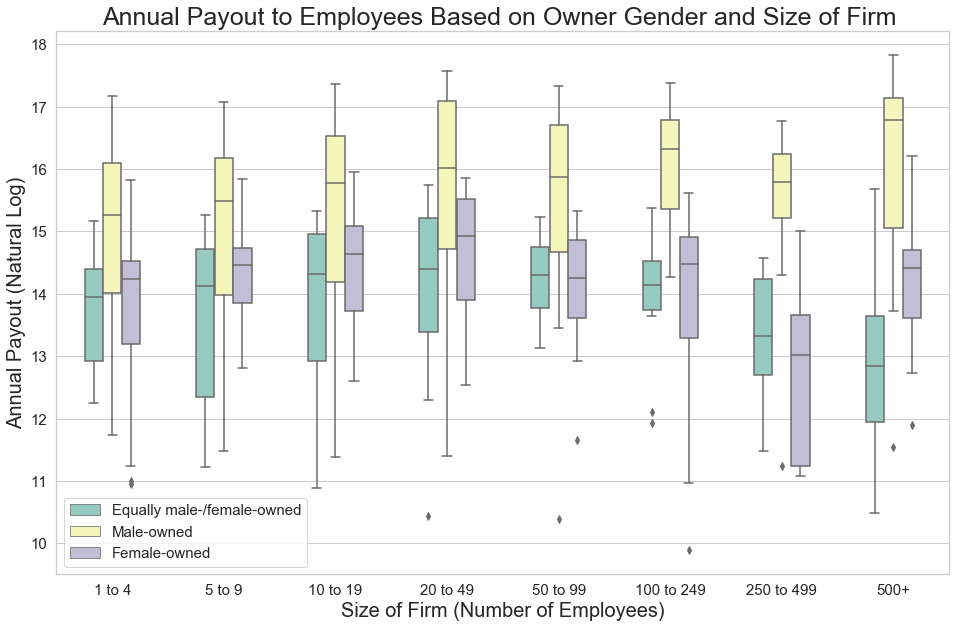

In [17]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 10))

sns.boxplot(x='empszfi_ttl_clean', y="payann_log", hue="sex_ttl", width = .5, data=df_sex_payann_naics_empszfi_empfm, palette="Set3")
plt.xlabel('Size of Firm (Number of Employees)', fontsize = 20)
plt.xticks(fontsize = 15)
plt.ylabel('Annual Payout (Natural Log)', fontsize = 20)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15, frameon = True,fancybox = True)
plt.title('Annual Payout to Employees Based on Owner Gender and Size of Firm ', fontsize = 25)
plt.savefig('img/boxplot.png', transparent=True, figure=fig)
plt.show()

### correlation between gender and annual payroll, grouped by gender

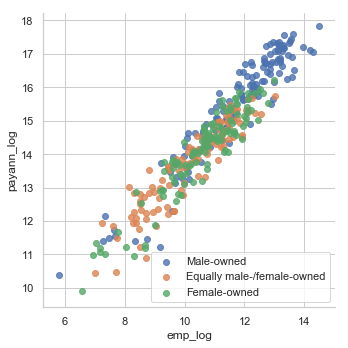

In [18]:
sns.lmplot( x="emp_log", y="payann_log", data=df_sex_payann_naics_empszfi, fit_reg=False, hue='sex_ttl', legend=False)
plt.legend(loc='lower right')

## H2: Entrepreneurs, regardless of their genders,  hire equal number of paid-employees

In [19]:
df_sex_female = df_sex_female.loc[df_sex_female.emp_log > 0]
df_sex_male = df_sex_male.loc[df_sex_male.emp_log > 0]
df_sex_both = df_sex_both.loc[df_sex_both.emp_log > 0]

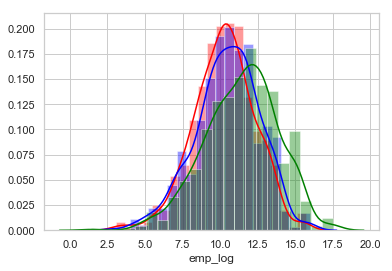

In [20]:
sns.distplot(df_sex_both.emp_log,color="red")
sns.distplot(df_sex_female.emp_log,color="blue")
sns.distplot(df_sex_male.emp_log,color="green")

In [21]:
print(stats.shapiro(df_sex_female.emp_log))
print(stats.shapiro(df_sex_male.emp_log))
print(stats.shapiro(df_sex_both.emp_log))

(0.9906202554702759, 0.0011521837441250682)
(0.990779459476471, 0.0002505732700228691)
(0.9926711320877075, 0.00537367258220911)


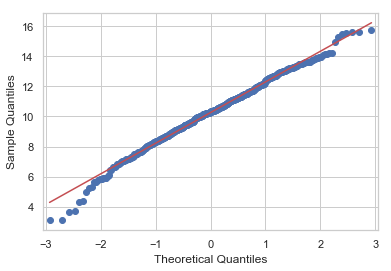

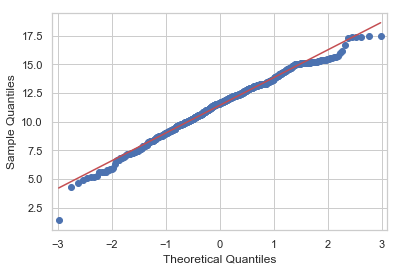

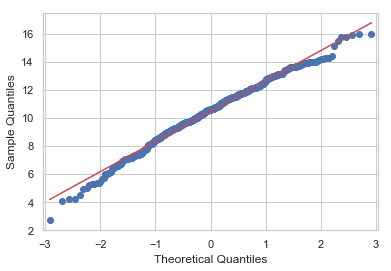

In [22]:
sm.qqplot(df_sex_both.emp_log,line='s')
sm.qqplot(df_sex_male.emp_log,line='s')
sm.qqplot(df_sex_female.emp_log,line='s')
pylab.show()

In [23]:
df_sex_female_emp_list = list(df_sex_female.emp_log)
df_sex_male_emp_list = list(df_sex_male.emp_log)
df_sex_both_emp_list = list(df_sex_both.emp_log)
from scipy.stats import mstats
pval_sex_hire = mstats.kruskalwallis(df_sex_both_emp_list,df_sex_female_emp_list,df_sex_male_emp_list)
pval_sex_hire

KruskalResult(statistic=98.19896539222458, pvalue=4.746413830053969e-22)

In [24]:
stats.f_oneway(df_sex_female_emp_list, df_sex_male_emp_list, df_sex_both_emp_list)

F_onewayResult(statistic=50.39405257513997, pvalue=4.902407055480284e-22)

### Number of paid-employees means by owners' gender

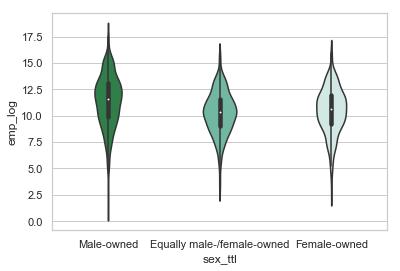

In [25]:
df_sex_emp = df
df_sex_emp = df_sex_emp.loc[(df_sex_emp.sex >1 ) & (df_sex_emp.sex < 5)]
df_sex_emp = df_sex_emp.loc[(df_sex_emp.emp_log > 0)]
sns.violinplot(x=df_sex_emp.sex_ttl, y=df_sex_emp.emp_log, palette="BuGn_r", width=0.3)

In [26]:
anova_sex_emp = ols('emp_log ~ C(sex_ttl)', data = df_sex_emp).fit()
print(anova_sex_emp.summary())

                            OLS Regression Results                            
Dep. Variable:                emp_log   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     50.39
Date:                Fri, 23 Aug 2019   Prob (F-statistic):           4.90e-22
Time:                        14:16:38   Log-Likelihood:                -4102.4
No. Observations:                1850   AIC:                             8211.
Df Residuals:                    1847   BIC:                             8227.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [27]:
sp.posthoc_conover(df_sex_emp, val_col='emp_log', group_col='sex_ttl', p_adjust = 'bonferroni')

,Equally male-/female-owned,Female-owned,Male-owned
Equally male-/female-owned,-1.000000e+00,9.998580e-02,5.522439e-21
Female-owned,9.998580e-02,-1.000000e+00,1.194940e-12
Male-owned,5.522439e-21,1.194940e-12,-1.000000e+00


## Part 2: Subset dataframe by race

## H3: Entrepreneurs, regardless of their race,  pay their employees equally

In [28]:
df_race_minority = df.loc[df.race_group == 90]
df_race_equal = df.loc[df.race_group == 91]
df_race_nonminority = df.loc[df.race_group == 92]

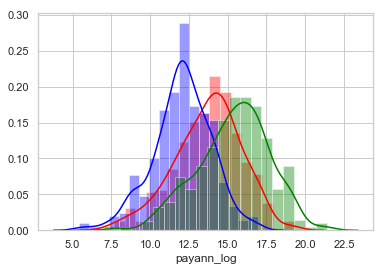

In [29]:
sns.distplot(df_race_minority.payann_log,color="red")
sns.distplot(df_race_equal.payann_log,color="blue")
sns.distplot(df_race_nonminority.payann_log,color="green")

In [30]:
print(stats.shapiro(df_race_minority.payann_log))
print(stats.shapiro(df_race_nonminority.payann_log))
print(stats.shapiro(df_race_equal.payann_log))

(0.989421010017395, 0.001957545755431056)
(0.989043653011322, 0.0002578000130597502)
(0.9889519214630127, 0.014712509699165821)


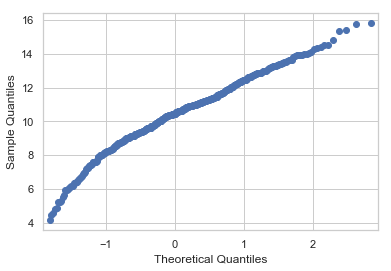

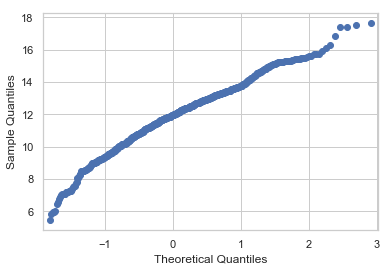

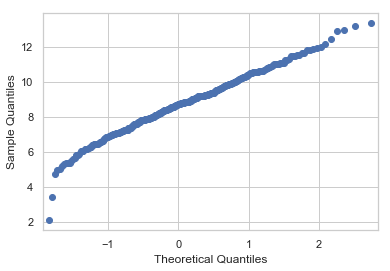

In [31]:
sm.qqplot(df_race_minority.emp_log,line='s')
sm.qqplot(df_race_nonminority.emp_log,line='s')
sm.qqplot(df_race_equal.emp_log,line='s')
pylab.show()

In [32]:
df_race_minority_list = list(df_race_minority.payann_log)
df_race_equal_list = list(df_race_equal.payann_log)
df_race_nonminority_list = list(df_race_nonminority.payann_log)

pval_race_pay = mstats.kruskalwallis(df_race_minority_list,df_race_equal_list,df_race_nonminority_list)
pval_race_pay

KruskalResult(statistic=379.4008707398398, pvalue=4.1128957751761335e-83)

In [33]:
stats.f_oneway(df_race_minority_list,df_race_equal_list,df_race_nonminority_list)

F_onewayResult(statistic=248.24402264355396, pvalue=1.1425252987339461e-92)

### Annual payroll means by owners' ethnicity

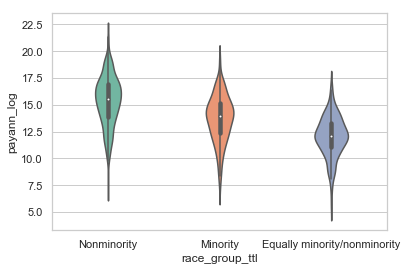

In [34]:
df_race_payann = df
df_race_payann = df_race_payann.loc[(df_race_payann.race_group > 89 ) & (df_race_payann.race_group < 93)]
sns.violinplot(x=df_race_payann.race_group_ttl, y=df_race_payann.payann_log, palette="Set2", width=0.3)

In [35]:
anova_race_payann = ols('payann_log ~ C(race_group_ttl)', data = df_race_payann).fit()
print(anova_race_payann.summary())

                            OLS Regression Results                            
Dep. Variable:             payann_log   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     248.2
Date:                Fri, 23 Aug 2019   Prob (F-statistic):           1.14e-92
Time:                        14:16:43   Log-Likelihood:                -2996.1
No. Observations:                1367   AIC:                             5998.
Df Residuals:                    1364   BIC:                             6014.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [36]:
sp.posthoc_conover(df_race_payann, val_col='payann_log', group_col='race_group_ttl', p_adjust = 'bonferroni')

,Equally minority/nonminority,Minority,Nonminority
Equally minority/nonminority,-1.000000e+00,4.249306e-27,4.756601e-96
Minority,4.249306e-27,-1.000000e+00,1.621443e-32
Nonminority,4.756601e-96,1.621443e-32,-1.000000e+00


## H4: Entrepreneurs, regardless of their race,  hire equal number of paid-employees

In [37]:
df_race_equal = df_race_equal.loc[df_race_equal.emp_log > 0]
df_race_minority = df_race_minority.loc[df_race_minority.emp_log > 0]
df_race_nonminority = df_race_nonminority.loc[df_race_nonminority.emp_log > 0]

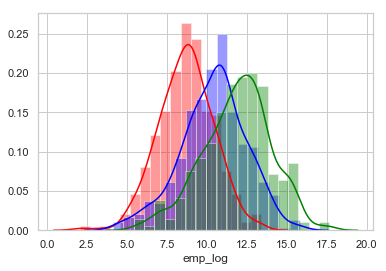

In [38]:
sns.distplot(df_race_equal.emp_log,color="red")
sns.distplot(df_race_minority.emp_log,color="blue")
sns.distplot(df_race_nonminority.emp_log,color="green")

In [39]:
print(stats.shapiro(df_race_equal.emp_log))
print(stats.shapiro(df_race_minority.emp_log))
print(stats.shapiro(df_race_nonminority.emp_log))

(0.9955005049705505, 0.5016911625862122)
(0.9911985397338867, 0.008893500082194805)
(0.9908356070518494, 0.0015234547900035977)


In [40]:
df_race_equal_emp_list = list(df_race_equal.emp_log)
df_race_minority_emp_list = list(df_race_minority.emp_log)
df_race_nonminority_emp_list = list(df_race_nonminority.emp_log)
from scipy.stats import mstats
pval_race_hire = mstats.kruskalwallis(df_race_equal_emp_list,df_race_minority_emp_list,df_race_nonminority_emp_list)
pval_race_hire

KruskalResult(statistic=388.15622673529367, pvalue=5.163525263609815e-85)

In [41]:
stats.f_oneway(df_race_equal_emp_list, df_race_minority_emp_list, df_race_nonminority_emp_list)

F_onewayResult(statistic=253.7447850405545, pvalue=5.68271618150574e-94)

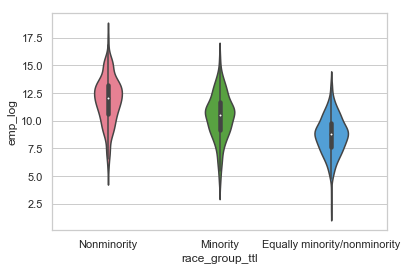

In [42]:
df_race_emp = df
df_race_emp = df_race_emp.loc[(df_race_emp.race_group > 89 ) & (df_race_emp.race_group < 93)]
df_race_emp = df_race_emp.loc[(df_race_emp.emp_log > 0)]
sns.violinplot(x=df_race_emp.race_group_ttl, y=df_race_emp.emp_log, palette="husl", width=0.3)

In [43]:
anova_race_emp = ols('emp_log ~ C(race_group_ttl)', data = df_race_emp).fit()
print(anova_race_emp.summary())

                            OLS Regression Results                            
Dep. Variable:                emp_log   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     253.7
Date:                Fri, 23 Aug 2019   Prob (F-statistic):           5.68e-94
Time:                        14:16:46   Log-Likelihood:                -2803.1
No. Observations:                1323   AIC:                             5612.
Df Residuals:                    1320   BIC:                             5628.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [44]:
sp.posthoc_conover(df_race_emp, val_col='emp_log', group_col='race_group_ttl', p_adjust = 'bonferroni')

,Equally minority/nonminority,Minority,Nonminority
Equally minority/nonminority,-1.000000e+00,1.729086e-32,2.799614e-100
Minority,1.729086e-32,-1.000000e+00,1.788456e-29
Nonminority,2.799614e-100,1.788456e-29,-1.000000e+00
